# Evaluate the Impact of Population-Weighting on Heat Wave Events


In [1]:
# Start by importing the packages we need:
import os
import glob
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


## Set the Directory Structure


In [2]:
# Identify the data input and image output directories:
service_territory_data_dir = '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/ba_service_territory_data/'
population_data_dir = '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/population_data/'
weather_data_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/wrf_tell_counties_output/historic/'
load_data_dir = '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/mlp_output/historic/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/nerc_analysis/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/nerc_analysis/plots/'


## Process the Weather and Load Time Series by BA


In [3]:
# Define a function to process the load time series for a given BA and date range:
def process_ba_load_time_series(ba_to_process: str, start_year: int, end_year: int, load_data_dir: str):
    
    # Loop over the years of load data:
    for year in range(start_year, end_year, 1):
        
        # Read in the .csv file and replace missing values with nan:
        mlp_data = pd.read_csv((load_data_dir + '/' + str(year) + '/' + ba_to_process + '_' + str(year) + '_mlp_output.csv')).replace(-9999, np.nan)

        # Set the time variable as a datetime variable:
        mlp_data['Time_UTC'] = pd.to_datetime(mlp_data['Time_UTC'])
        
        # Rename the "BA" variable:
        mlp_data.rename(columns={'BA': 'BA_Code'}, inplace=True)

        # Rename the "Load" variable:
        mlp_data.rename(columns={'Load': 'Load_MWh'}, inplace=True)

        # Replacing missing or negative loads with NaN:
        mlp_data.loc[~(mlp_data['Load_MWh'] > 0), 'Load_MWh'] = np.nan

        # Subset to just the variables we need:
        mlp_data = mlp_data[['Time_UTC', 'Load_MWh']]
    
        # Aggregate the output into a new dataframe:
        if year == start_year:
           mlp_output_df = mlp_data
        else:
           mlp_output_df = pd.concat([mlp_output_df, mlp_data])
        
    return mlp_output_df


In [4]:
# Define a function to process the time series for a given BA and date range:
def process_ba_time_series(ba_to_process: str, start_year: int, end_year: int, weather_data_dir: str, service_territory_data_dir: str, 
                           population_data_dir: str, load_data_dir: str, data_output_dir: str):
    
    # Read in the county-level population data:
    pop_df = pd.read_csv(population_data_dir + 'county_populations_2000_to_2020.csv')

    # Subset to just the variables we need:
    pop_df = pop_df[['county_FIPS', 'pop_2019']]

    # Rename the variables for simplicity:
    pop_df.rename(columns={'county_FIPS': 'FIPS', 'pop_2019': 'Population'}, inplace=True)
    
    # Read in the BA-to-county mapping file:
    mapping_df = pd.read_csv(service_territory_data_dir + 'ba_service_territory_2019.csv')
    
    # Subset to just the BA you want to process:
    mapping_df = mapping_df.loc[(mapping_df['BA_Code'] == ba_to_process)]
    
    # Rename the variables for simplicity:
    mapping_df.rename(columns={'County_FIPS': 'FIPS'}, inplace=True)
    
    # Subset to just the variables we need:
    mapping_df = mapping_df[['BA_Code', 'FIPS']]
    
    # Initiate a counter to store the results:
    counter = 0;
    output_df = pd.DataFrame()
    
    # Loop over the years of weather data:
    for year in range(start_year, end_year, 1):
        
        # Print the year
        print(str(year))
        
        # Create a list of all county meteorology files in the input directory:
        list_of_files = glob(os.path.join(weather_data_dir, str(year), '*.csv'))
    
        # Loop over that list process each file:
        for file in range(len(list_of_files)):
        # for file in range(1):
            # Iterate the counter by one:
            counter = counter + 1
        
            # Extract the filename from the list:
            filename = list_of_files[file].rsplit('/', 1)[1]
       
            # Extract the time string from the name of the file:
            filetime = filename.replace("_UTC_County_Mean_Meteorology.csv", "")
            
            # Read in the .csv file:
            met_df = pd.read_csv(list_of_files[file])
            
            # Convert the temperature from Kelvin to Fahrenheit:
            met_df['T2'] = (1.8 * (met_df['T2'] - 273)) + 32
        
            # Merge the meteorology and population data into the mapping_df
            ba_df = mapping_df.merge(met_df, on=['FIPS']).merge(pop_df, on=['FIPS'])
        
            # Compute the fraction of the total population in the BA that lives in a given county:
            ba_df['Population_Fraction'] = ba_df['Population'] / (ba_df['Population'].sum())

            # Population-weight T2:
            ba_df['T2_Weighted'] = (ba_df['T2'].mul(ba_df['Population_Fraction']))
       
            # Add the time step to the output file:
            output_df.loc[counter, 'Time_UTC'] = pd.to_datetime(filetime, exact=False, format='%Y_%m_%d_%H')
            output_df.loc[counter, 'T2_UW'] = (ba_df['T2'].mean()).round(2)
            output_df.loc[counter, 'T2_PW'] = (ba_df['T2_Weighted'].sum()).round(2)
            output_df.loc[counter, 'T2_Min'] = ba_df['T2'].min().round(2)
            output_df.loc[counter, 'T2_Max'] = ba_df['T2'].max().round(2)
            
            # Clean up the old dataframes and move to the next file in the loop:
            del filename, filetime, met_df, ba_df
        
    # Sort by time:
    output_df = output_df.sort_values(['Time_UTC'])
    
    # Aggregate the TELL MLP output for the BA and date range:
    load_df = process_ba_load_time_series(ba_to_process = ba_to_process, 
                                          start_year = start_year, 
                                          end_year = end_year, 
                                          load_data_dir = load_data_dir)
    
    # Merge the meteorology and load data:
    output_df = output_df.merge(load_df, on=['Time_UTC'])
        
    # Create the ouput filename:    
    csv_output_filename = os.path.join(data_output_dir, (ba_to_process + '_Time_Series_' + str(start_year) + '_to_' + str(end_year) + '.csv'))
        
    # Write out the dataframe to a .csv file:
    output_df.to_csv(csv_output_filename, sep=',', index=False)
    
    return output_df


In [ ]:
output_df = process_ba_time_series(ba_to_process = 'CISO', 
                                   start_year = 1980, 
                                   end_year = 2020, 
                                   weather_data_dir = weather_data_dir, 
                                   service_territory_data_dir = service_territory_data_dir, 
                                   population_data_dir = population_data_dir, 
                                   load_data_dir = load_data_dir, 
                                   data_output_dir = data_output_dir)

output_df


## Classify Heat Wave Events Based on Historical Temperatures


In [5]:
# Define a function to classify heat wave events based on one criteria:
#  1) Daily maximum temperature exceeds the 95th percentile of temperature from a given range of base years for two or more days

def process_heat_wave_time_series(ba_to_process: str, start_year: int, end_year: int, base_year_start: int, base_year_end: int,
                                  weather_data_dir: str, service_territory_data_dir: str, 
                                  population_data_dir: str, load_data_dir: str, data_output_dir: str):
    
    # Check to see if the output already exist and if not then process it:
    if os.path.isfile(os.path.join(data_output_dir, (ba_to_process + '_Time_Series_' + str(start_year) + '_to_' + str(end_year) + '.csv'))) == True:
       # Load in the pre-processed data:
       met_df = pd.read_csv(os.path.join(data_output_dir, (ba_to_process + '_Time_Series_' + str(start_year) + '_to_' + str(end_year) + '.csv')))
    else:
       met_df = process_ba_time_series(ba_to_process = ba_to_process, 
                                       start_year = start_year, 
                                       end_year = end_year, 
                                       weather_data_dir = weather_data_dir, 
                                       service_territory_data_dir = service_territory_data_dir, 
                                       population_data_dir = population_data_dir, 
                                       load_data_dir = load_data_dir, 
                                       data_output_dir = data_output_dir)
    
    # Make a copy of the dataframe for later:
    output_df = met_df.copy()
    
    # Set the time variable as an index:
    met_df.index = pd.to_datetime(met_df['Time_UTC'])
        
    # Compute the daily minimum and maximum temperature using resampling:
    uw_df = met_df.resample('D')['T2_UW'].agg(['min', 'max']).reset_index()
    pw_df = met_df.resample('D')['T2_PW'].agg(['min', 'max']).reset_index()
        
    # Rename the variables for consistency:
    uw_df.rename(columns={'Time_UTC': 'Day', 'min': 'T2_UW_Min', 'max': 'T2_UW_Max'}, inplace=True)      
    pw_df.rename(columns={'Time_UTC': 'Day', 'min': 'T2_PW_Min', 'max': 'T2_PW_Max'}, inplace=True)      
   
    # Merge the two dataframes together based on common days:
    daily_df = uw_df.merge(pw_df, on=['Day'])
    
    # Add a column with the year values to be used in grouping:
    daily_df['Year'] = daily_df['Day'].dt.year
        
    # Subset the daily data to just the base year to calculate extreme temperature thresholds:
    daily_df_subset = daily_df.loc[(daily_df['Year'] >= base_year_start) & (daily_df['Year'] <= base_year_end)]
    
    # Calculate the temperature thresholds based on the 95th percentile of historical daily maximum temperature:
    uw_t_threshold = daily_df_subset['T2_UW_Max'].quantile(0.95).round(2)
    pw_t_threshold = daily_df_subset['T2_PW_Max'].quantile(0.95).round(2)
    
    # Print the values:
    print(('Unweighted Temperature Threshold = ' + str(uw_t_threshold) + 'F'))
    print(('Population-Weighted Temperature Threshold = ' + str(pw_t_threshold) + 'F'))
    
    # Create some heat wave index variables:
    daily_df['UW_Heat_Wave_Initial'] = 0
    daily_df['PW_Heat_Wave_Initial'] = 0
    daily_df['UW_Heat_Wave_Final'] = 0
    daily_df['PW_Heat_Wave_Final'] = 0
    daily_df['Joint_Heat_Wave_Final'] = 0
    
    # Mark the heat waves based on days that exceed the temperature threshold:
    daily_df.loc[daily_df['T2_UW_Max'] >= uw_t_threshold, 'UW_Heat_Wave_Initial'] = 1
    daily_df.loc[daily_df['T2_PW_Max'] >= pw_t_threshold, 'PW_Heat_Wave_Initial'] = 1
    
    # Loop through the dataframe and check to see if consecutive days exceed the temperature threshold:
    #daily_df['Test'] = (daily_df['UW_Heat_Wave_Initial'].diff(1)).astype('int')
    for row in range(1,(len(daily_df)-1)):
        if (((daily_df.loc[row, 'UW_Heat_Wave_Initial'] == 1) and (daily_df.loc[(row+1), 'UW_Heat_Wave_Initial'] == 1)) | 
            ((daily_df.loc[row, 'UW_Heat_Wave_Initial'] == 1) and (daily_df.loc[(row-1), 'UW_Heat_Wave_Initial'] == 1))):
           daily_df.loc[row, 'UW_Heat_Wave_Final'] = 1
        if (((daily_df.loc[row, 'PW_Heat_Wave_Initial'] == 1) and (daily_df.loc[(row+1), 'PW_Heat_Wave_Initial'] == 1)) | 
            ((daily_df.loc[row, 'PW_Heat_Wave_Initial'] == 1) and (daily_df.loc[(row-1), 'PW_Heat_Wave_Initial'] == 1))):
           daily_df.loc[row, 'PW_Heat_Wave_Final'] = 1
        if (daily_df.loc[row, 'UW_Heat_Wave_Final'] == 1) and (daily_df.loc[row, 'PW_Heat_Wave_Final'] == 1):
           daily_df.loc[row, 'Joint_Heat_Wave_Final'] = 1
    
    # Rename the variables for simplicity:
    daily_df.rename(columns={'UW_Heat_Wave_Final': 'UW_HW', 'PW_Heat_Wave_Final': 'PW_HW', 'Joint_Heat_Wave_Final': 'Joint_HW'}, inplace=True)
    
    # Subset to just the variables we need:
    daily_df = daily_df[['Day', 'UW_HW', 'PW_HW', 'Joint_HW']]
    
    # Set the time variable as a datetime variable:
    daily_df['Date'] = pd.to_datetime(daily_df['Day'])
    daily_df['Day'] = daily_df['Date'].dt.strftime('%Y-%m-%d')
    
    # Set the time variable as an index:
    output_df['Time_UTC'] = pd.to_datetime(output_df['Time_UTC'])
    
    # Reset the index:
    output_df.reset_index()
    
    # Add a column with the day values to be used in grouping:
    output_df['Day'] = output_df['Time_UTC'].dt.strftime('%Y-%m-%d')
    
    # Merge the two dataframes together based on common days:
    output_df = output_df.merge(daily_df, on=['Day'])
    
    # Subset to just the variables we need:
    output_df = output_df[['Time_UTC', 'T2_UW', 'T2_PW', 'T2_Min', 'T2_Max', 'Load_MWh', 'UW_HW', 'PW_HW', 'Joint_HW']]
    
    # Create the ouput filename:    
    csv_output_filename = os.path.join(data_output_dir, (ba_to_process + '_Heat_Wave_Time_Series_' + str(start_year) + '_to_' + str(end_year) + '.csv'))
        
    # Write out the dataframe to a .csv file:
    output_df.to_csv(csv_output_filename, sep=',', index=False)
    
    return output_df


In [ ]:
output_df = process_heat_wave_time_series(ba_to_process = 'CISO', 
                                          start_year = 1980, 
                                          end_year = 2020, 
                                          base_year_start = 1980,
                                          base_year_end = 1990,
                                          weather_data_dir = weather_data_dir, 
                                          service_territory_data_dir = service_territory_data_dir, 
                                          population_data_dir = population_data_dir, 
                                          load_data_dir = load_data_dir, 
                                          data_output_dir = data_output_dir)

output_df


## Make the Plots to Characterize the Results


In [56]:
def plot_heat_wave_frequency(ba_to_process: str, start_year: int, end_year: int, base_year_start: int, base_year_end: int,
                             weather_data_dir: str, service_territory_data_dir: str, 
                             population_data_dir: str, load_data_dir: str, data_output_dir: str,
                             image_output_dir: str, image_resolution: int, save_images=False):
    
    # Check to see if the output already exist and if not then process it:
    if os.path.isfile(os.path.join(data_output_dir, (ba_to_process + '_Heat_Wave_Time_Series_' + str(start_year) + '_to_' + str(end_year) + '.csv'))) == True:
       # Load in the pre-processed data:
       met_df = pd.read_csv(os.path.join(data_output_dir, (ba_to_process + '_Heat_Wave_Time_Series_' + str(start_year) + '_to_' + str(end_year) + '.csv')))
    else:
       met_df = process_heat_wave_time_series(ba_to_process = ba_to_process, 
                                              start_year = start_year, 
                                              end_year = end_year, 
                                              base_year_start = base_year_start,
                                              base_year_end = base_year_end,
                                              weather_data_dir = weather_data_dir, 
                                              service_territory_data_dir = service_territory_data_dir, 
                                              population_data_dir = population_data_dir, 
                                              load_data_dir = load_data_dir, 
                                              data_output_dir = data_output_dir)
    
    # Set the time variable as an index:
    met_df.index = pd.to_datetime(met_df['Time_UTC'])
    
    # Compute the daily minimum and maximum temperature using resampling:
    uw_df = met_df.resample('D')['T2_UW'].agg(['min', 'max']).reset_index()
    pw_df = met_df.resample('D')['T2_PW'].agg(['min', 'max']).reset_index()
    uw_hw_df = met_df.resample('D')['UW_HW'].agg(['max']).reset_index()
    pw_hw_df = met_df.resample('D')['PW_HW'].agg(['max']).reset_index()
    joint_hw_df = met_df.resample('D')['Joint_HW'].agg(['max']).reset_index()
        
    # Rename the variables for consistency:
    uw_df.rename(columns={'Time_UTC': 'Day', 'min': 'T2_UW_Min', 'max': 'T2_UW_Max'}, inplace=True)      
    pw_df.rename(columns={'Time_UTC': 'Day', 'min': 'T2_PW_Min', 'max': 'T2_PW_Max'}, inplace=True)      
    uw_hw_df.rename(columns={'Time_UTC': 'Day', 'max': 'UW_HW'}, inplace=True)  
    pw_hw_df.rename(columns={'Time_UTC': 'Day', 'max': 'PW_HW'}, inplace=True)
    joint_hw_df.rename(columns={'Time_UTC': 'Day', 'max': 'Joint_HW'}, inplace=True) 
   
    # Merge the two dataframes together based on common days:
    daily_df = uw_df.merge(pw_df, on=['Day']).merge(uw_hw_df, on=['Day']).merge(pw_hw_df, on=['Day']).merge(joint_hw_df, on=['Day'])
    
    # Make the plot:
    fig, ax = plt.subplots(2, figsize=(25, 15), sharex=True, sharey=True)
    plt.rcParams['font.size'] = 18
    ax[0].plot(daily_df['Day'], 200*daily_df['UW_HW'], 'r-', label='Unweighted Heat Waves', linewidth=1)
    ax[0].plot(daily_df['Day'], daily_df['T2_UW_Max'], 'k-', label='Unweighted T2 Max', linewidth=1)
    ax[1].plot(daily_df['Day'], 200*daily_df['PW_HW'], 'r-', label='Pop-Weighted Heat Waves', linewidth=1)
    ax[1].plot(daily_df['Day'], daily_df['T2_PW_Max'], 'k-', label='Pop-Weighted T2 Max', linewidth=1)
    plt.xlim(daily_df['Day'].min(), daily_df['Day'].max())
    plt.ylim(daily_df[['T2_UW_Max', 'T2_PW_Max']].min().min(), daily_df[['T2_UW_Max', 'T2_PW_Max']].max().max())
    ax[0].set_title((ba_to_process + ' Unweighted Daily Maximum Temperature: ' + str(start_year) + ' to ' + str(end_year)))
    ax[1].set_title((ba_to_process + ' Population-Weighted Daily Maximum Temperature: ' + str(start_year) + ' to ' + str(end_year)))
    ax[0].set_ylabel('Daily Maximum Temperature [$^\circ$F]')
    ax[1].set_ylabel('Daily Maximum Temperature [$^\circ$F]')
    
    return daily_df


,Day,T2_UW_Min,T2_UW_Max,T2_PW_Min,T2_PW_Max,UW_HW,PW_HW,Joint_HW
0,1980-01-01,34.28,58.79,32.41,57.63,0,0,0
1,1980-01-02,39.54,60.55,36.58,61.59,0,0,0
2,1980-01-03,42.65,54.94,47.18,56.56,0,0,0
3,1980-01-04,32.65,53.25,32.07,51.44,0,0,0
4,1980-01-05,34.18,56.45,32.52,55.97,0,0,0
...,...,...,...,...,...,...,...,...
14605,2019-12-27,52.88,64.19,54.25,68.41,0,0,0
14606,2019-12-28,57.10,66.42,57.89,70.01,0,0,0
14607,2019-12-29,45.89,60.87,50.71,64.48,0,0,0
14608,2019-12-30,34.04,54.29,33.72,56.75,0,0,0


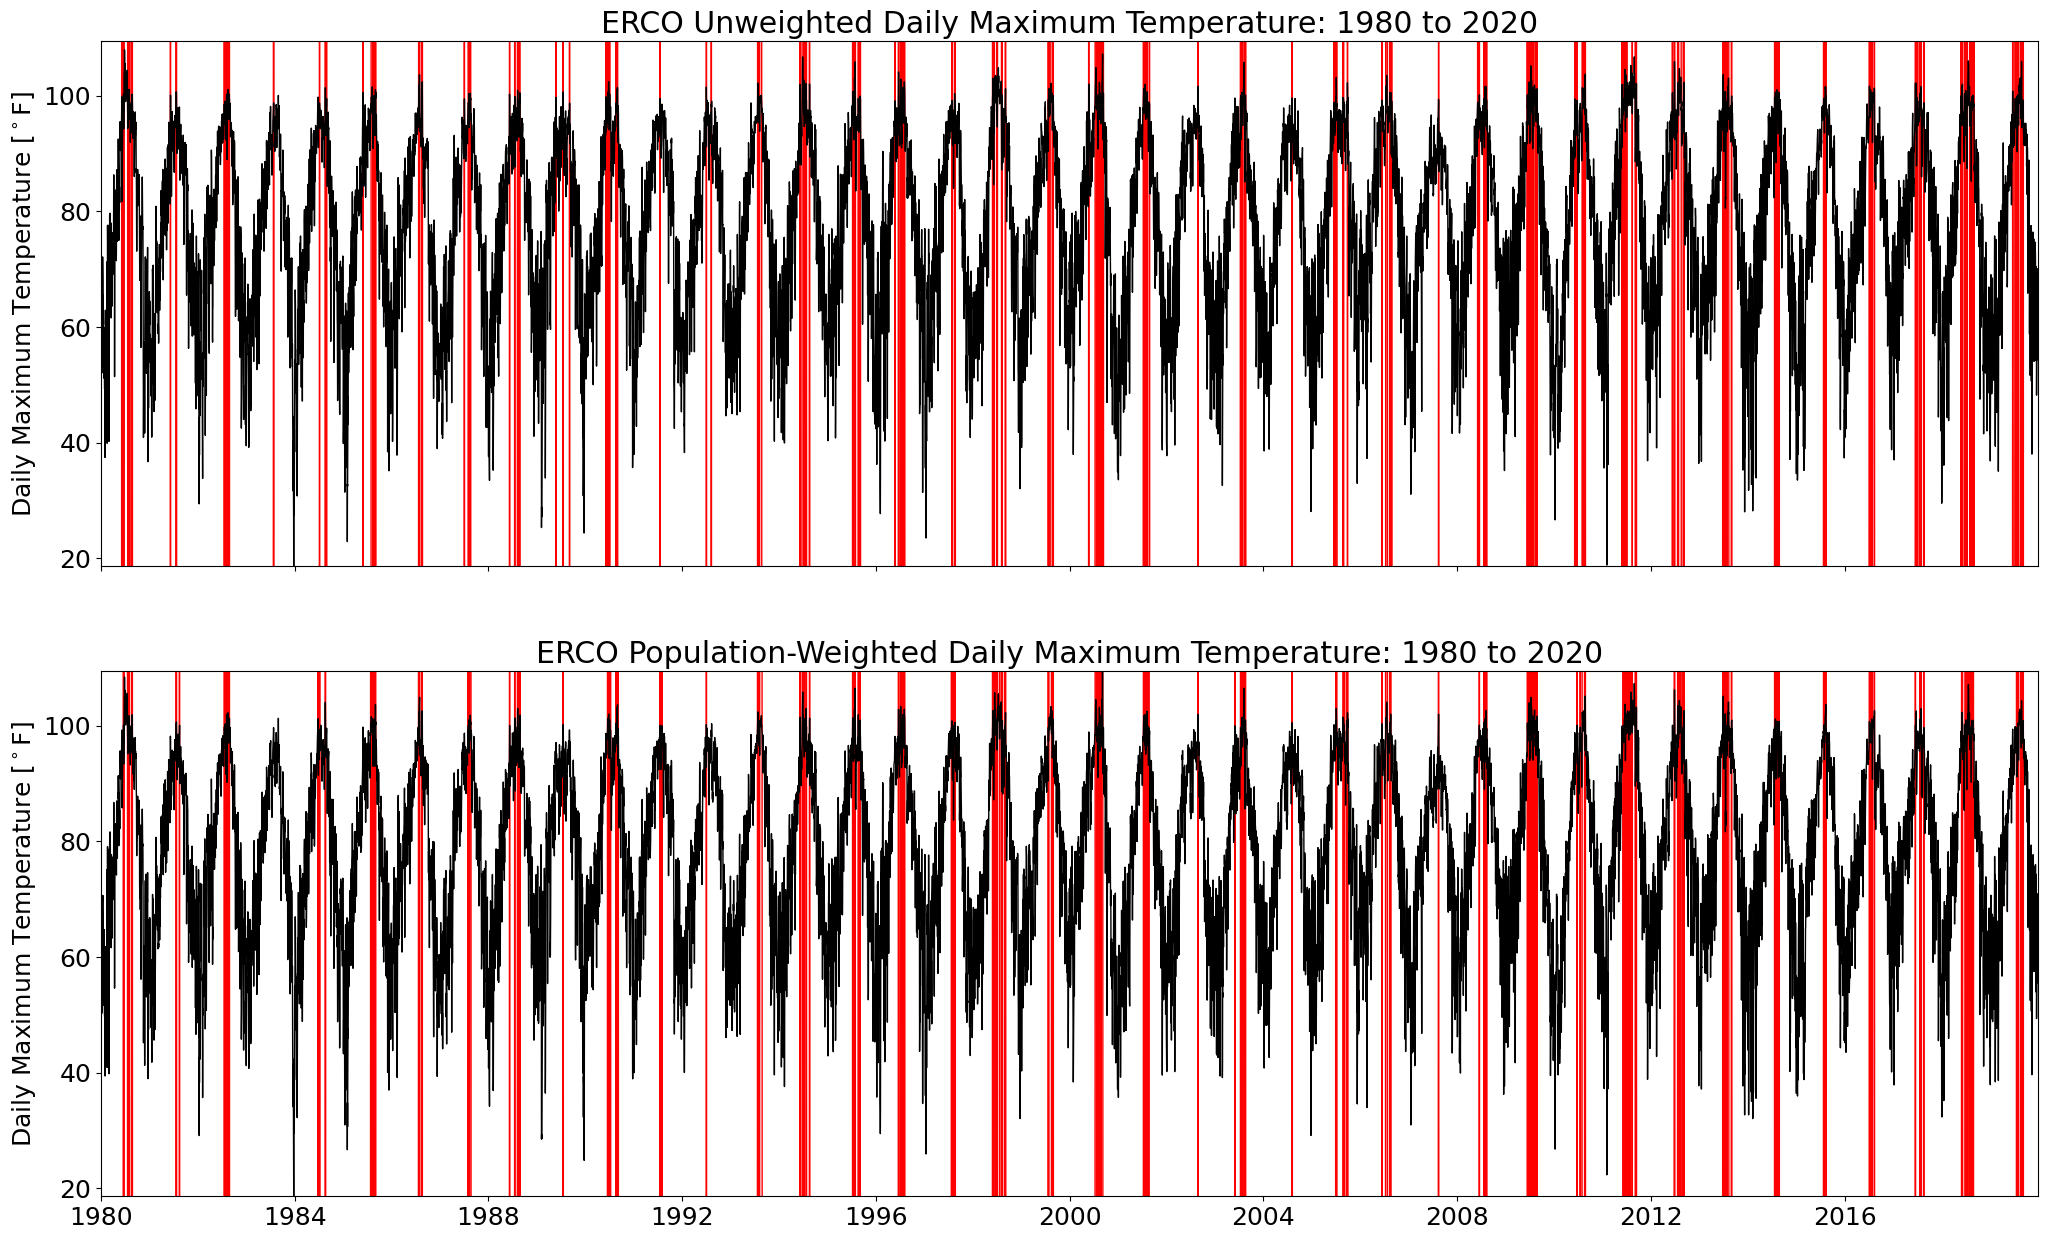

In [58]:
output_df = plot_heat_wave_frequency(ba_to_process = 'ERCO', 
                                     start_year = 1980, 
                                     end_year = 2020, 
                                     base_year_start = 1980,
                                     base_year_end = 1990,
                                     weather_data_dir = weather_data_dir, 
                                     service_territory_data_dir = service_territory_data_dir, 
                                     population_data_dir = population_data_dir, 
                                     load_data_dir = load_data_dir, 
                                     data_output_dir = data_output_dir,
                                     image_output_dir = image_output_dir, 
                                     image_resolution = 300, 
                                     save_images = False)

output_df
